In [1]:
import torchvision 
import torch.nn as nn 
import torch 
import torch.nn.functional as F 
from torchvision import transforms,models,datasets 
import matplotlib.pyplot as plt 
from PIL import Image 
import numpy as np 
from torch import optim 

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import pandas as pd
import seaborn as sns

In [2]:
data_dir = "D:/DatasetsCD/binary_classification_covid_dataset"

transform = transforms.Compose([transforms.Resize(255), 
    transforms.CenterCrop(224), 
    transforms.RandomHorizontalFlip(),                            
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])]) 

dataset = torchvision.datasets.ImageFolder(data_dir, transform= transform)


In [3]:
## spliting dataset 80 % training,20 % VALIDATION 
train_dataset, val_dataset = random_split(dataset,(2000,541))

In [4]:
training_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=32)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=1)

print("Length of the train_loader:", len(training_loader))
print("Length of the val_loader:", len(val_loader))

Length of the train_loader: 63
Length of the val_loader: 541


In [5]:
inputs, classes = next(iter(training_loader))  
inputs.shape,classes.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [2]:

device = torch.device("cuda:0")
if torch.cuda.is_available():
    device = torch.device("cuda:0")  #
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [3]:
model = models.vgg16(pretrained=True).to(device) # freeze all the parameters except the final layer 
    
for param in model.parameters():
    param.requires_grad = False   
    
classifier = nn.Sequential(
               nn.Linear(25088, 4096),
               nn.ReLU(inplace=True),
               nn.Linear(4096, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 1),
               nn.Sigmoid()).to(device)
model.classifier = classifier
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
img = inputs.to(device)
print(img.shape)
a = model(img)
a.shape

torch.Size([32, 3, 224, 224])


torch.Size([32, 1])

In [8]:
import torch.optim as optim


criterion = nn.BCELoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)



In [9]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)
    
    correct_result_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_result_sum/y_test.shape[0]
    acc  = torch.round(acc*100)
    
    return acc
    

In [10]:
torch.cuda.empty_cache()

In [11]:
## one neurone output and sigmoid, BCELOO

print("Begin training...")

accuracy_stats = {
    'train': [],
    "val": []
             }
loss_stats = {
    'train': [],
    "val": []
             }
Epochs= 10

for epoch in range(Epochs):
    #training
    
    train_epoch_loss = 0
    train_epoch_acc  = 0
    
    model.train()
    for X_train_batch, y_train_batch in training_loader:
        y_train_batch = y_train_batch.to(torch.float32)
        X_train_batch , y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        optimizer.zero_grad()
        
        y_train_pred  = model(X_train_batch)
        
        train_loss = criterion( y_train_pred,y_train_batch.unsqueeze(1))
        train_acc = binary_acc(y_train_pred,y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    #training
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
    
        for X_val_batch, y_val_batch in val_loader:
            y_val_batch = y_val_batch.to(torch.float32)
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)
            #y_val_pred = torch.unsqueeze(y_val_pred, 0)

            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            val_acc = binary_acc(y_val_pred, y_val_batch.unsqueeze(1))

            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
        
    loss_stats['train'].append(train_epoch_loss/len(training_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(training_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader)) 
            
    print(f"Epoch: {epoch}| train-loss: {train_epoch_loss/len(training_loader)}| val-loss: {val_epoch_loss/len(val_loader)} | train_accuracy : {train_epoch_acc/len(training_loader)} | val_accuracy : {val_epoch_acc/len(val_loader)} ")
      

Begin training...
Epoch: 0| train-loss: 0.675229081010568| val-loss: 0.6157755627112109 | train_accuracy : 96.01587301587301 | val_accuracy : 98.70609981515712 
Epoch: 1| train-loss: 0.5779184177307053| val-loss: 0.49233327868757926 | train_accuracy : 99.0 | val_accuracy : 98.52125693160814 
Epoch: 2| train-loss: 0.4068510263951819| val-loss: 0.18484346260398996 | train_accuracy : 99.28571428571429 | val_accuracy : 99.81515711645102 
Epoch: 3| train-loss: 0.23811824617193567| val-loss: 0.2220820241240872 | train_accuracy : 99.47619047619048 | val_accuracy : 99.26062846580406 
Epoch: 4| train-loss: 0.25888552204958115| val-loss: 0.033088735617571786 | train_accuracy : 99.57142857142857 | val_accuracy : 99.44547134935306 
Epoch: 5| train-loss: 0.04316918833734532| val-loss: 0.009493510522626947 | train_accuracy : 99.38095238095238 | val_accuracy : 99.63031423290204 
Epoch: 6| train-loss: 0.00903730103131008| val-loss: 0.0033743482392579694 | train_accuracy : 99.71428571428571 | val_accur

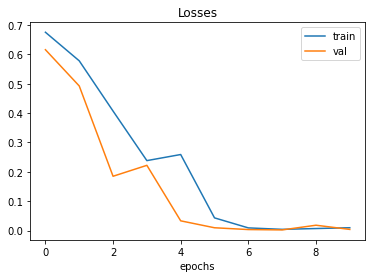

In [13]:
for v,c in sorted(loss_stats.items()):
    plt.plot(c,label=v)
plt.xlabel('epochs')
plt.title('Losses')
plt.legend()
plt.show()
#plt.plot(loss

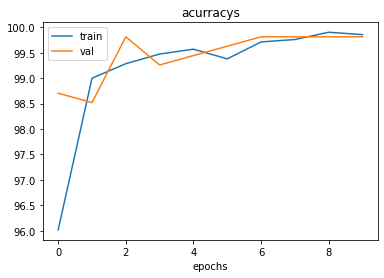

In [14]:
for v,c in sorted(accuracy_stats.items()):
    plt.plot(c,label=v)
plt.xlabel('epochs')
plt.title('acurracys')
plt.legend()
plt.show()

In [12]:
torch.save(model.state_dict(), 'model_weights_vgg16_transferlearning.pth')

In [5]:
model.load_state_dict(torch.load('model_weights_vgg16_transferlearning.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
#preparing test data 
data_dir = "D:/DatasetsCD/Test_set"


transforms2 = transforms.Compose([transforms.Resize((224,224)),
                                  
                                  transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                       std=[0.229, 0.224, 0.225])
                                                           ])

dataset2 =datasets.ImageFolder(data_dir, transform= transforms2)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1 ,shuffle=True) 

In [7]:
print(len(test_loader))
dataset2.class_to_idx

606


{'COVID': 0, 'NORMAL': 1}

In [8]:
y_true =[]
y_predicted = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x,batch_y = batch_x.to(device),batch_y.to(device)
        
        y_test_pred = model(batch_x)
        y_pred_tag = torch.round(y_test_pred)
        
       
        y_predicted.append(y_pred_tag.cpu().numpy())
        y_true.append(batch_y.cpu().numpy())

In [10]:
y_predicted = np.array(y_predicted)
y_predicted = y_predicted.reshape(606,)

y_true =  np.array(y_true)
y_true = y_true.reshape(606,)



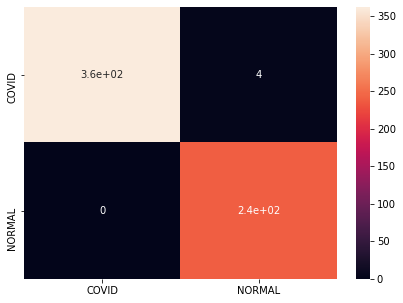

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
idx2class = {v: k for k, v in dataset2.class_to_idx.items()}
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, y_predicted)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

In [22]:
print(classification_report(y_predicted, y_true))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       362
         1.0       1.00      0.98      0.99       244

    accuracy                           0.99       606
   macro avg       0.99      0.99      0.99       606
weighted avg       0.99      0.99      0.99       606



Text(0, 0.5, 'True Positive Rate')

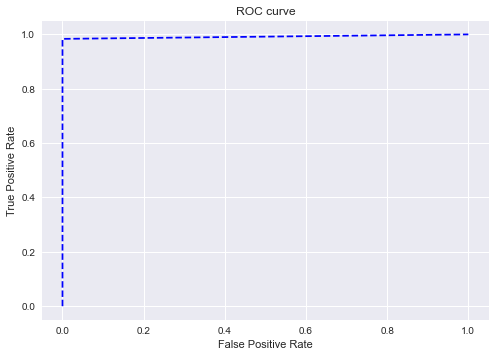

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_predicted,y_true, pos_label = 1)

import matplotlib.pyplot as plt 
plt.style.use('seaborn')

plt.plot(fpr,tpr,  linestyle = '--', color = 'blue', label = 'ResNet54')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')